# Import stuff

In [1]:
from __future__ import absolute_import

import ray
import time
import threading

import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append("../")

from src import utils
from src.link_adaptation_agents import MultiArmedBandit as MAB_agent
from src.link_adaptation_agents import OuterLoopLinkAdaptation as OLLA_agent

np.set_printoptions(precision=3, suppress=True, threshold=np.inf)

/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:496: 

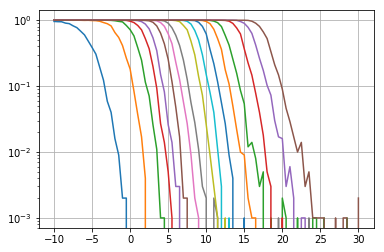

In [2]:
offline_model_datafile = 'Offline_Link_Model.npy'
offline_model = np.load( offline_model_datafile, encoding='latin1', allow_pickle=True )[ ( ) ]

snr_vs_bler = np.array(offline_model['snr_vs_bler'])
snr_range_dB = np.array(offline_model['snr_range_dB'])

nrof_snr, nrof_mcs = snr_vs_bler.shape

plt.figure()
plt.grid(True)
for i in range(nrof_mcs):
    plt.semilogy(snr_range_dB, snr_vs_bler[:, i])
    
plt.show()

In [3]:
modorder = offline_model["modulation_order"]
tbs = offline_model["block_size"]

# Utility functions for handling lists

In [4]:
def flatten( list_ ):
    return [ item for sublist in list_ for item in sublist ]

def stack( list_, sublist_size ):
    nrof_sublists = int( len( list_ ) / sublist_size ) 
    return [ list_[ i * sublist_size : ( i + 1 ) * sublist_size ] for i in range( nrof_sublists ) ]

# Wrap environment as Ray actor

In [5]:
@ray.remote( num_cpus = 0 )
class myenv( ):
    def __init__( self, env_name, nrof_instances ):
        import gym
        import gym_radio_link
        self.envs = [ gym.make( env_name ) for _ in range( nrof_instances ) ]
        
    def seed( self, seed_values ):
        return [ env.seed( seed ) for env, seed in zip( self.envs, seed_values ) ]
    
    def step( self, actions ):
        return [ env.step(action) for env, action in zip( self.envs, actions ) ]
    
    def reset( self ):
        return [ env.reset( ) for env in self.envs ]

# Define Environment Parameters

In [6]:
# Environment parameters
env_name = 'MCSSelection-v0'
nrof_actions = nrof_mcs
nrof_tti = 100
cqi_delay = 0

nrof_actors = 8
nrof_links_per_actor = 4 * 8

nrof_iter = int( 2 ** 14 / ( nrof_actors * nrof_links_per_actor ) )

nrof_links = nrof_actors * nrof_links_per_actor

# Reinforcement learning parameters
obs_window = cqi_delay + 1
learning_rate = 5e-4
ann_layout = [ 16, 8, 8, 16 ]

minibatch_size = min(16, nrof_links)
sgd_iter = 8

# Simulation parameters
bler_target = 1.3

olla_bler_target = 0.1
olla_step_size = 0.1

print(nrof_iter)
print(nrof_links)

64
256


# Collect parameters and create sim directory

In [7]:
parameters = { 'env_name': env_name,
               'obs_window': obs_window,
               'nrof_tti': nrof_tti,
               'cqi_delay': cqi_delay,
               'nrof_links': nrof_links,
               'bler_target': bler_target,
               'learning_rate': learning_rate,
               'ann_layout': ann_layout,
               'minibatch_size': minibatch_size,
               'sgd_iter': sgd_iter,
               'olla_bler_target': olla_bler_target,
               'olla_step_size': olla_step_size,
               'nrof_iter': nrof_iter}

In [8]:
sim_dir = utils.create_new_simulation_directory( base_dir='../final_results' )

print( 'Sim directory: ' + sim_dir )

np.save( sim_dir + '/simulation_parameters.npy', parameters )

Sim directory: ../final_results/000001/


# Init Ray

In [9]:
ray_redis_address = "0.0.0.0:0000" # Supply the address of the Redis server for your local Ray cluster.

ray.init(redis_address = ray_redis_address)

{'node_ip_address': '172.18.0.8',
 'redis_address': '172.18.0.8:15672',
 'object_store_address': '/tmp/ray/session_2020-01-29_11-16-35_11261/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-01-29_11-16-35_11261/sockets/raylet',
 'webui_url': None}

In [10]:
@ray.remote
def f( ):
    time.sleep( 0.01 )
    return ray.services.get_node_ip_address( )

# Get a list of the IP addresses of the nodes that have joined the cluster.
set( ray.get( [ f.remote( ) for _ in range( 100 ) ] ) )

{'172.18.0.8'}

In [11]:
rl_agent_statistics   = { 'tti': [ ], 'obs': [ ], 'actions': [ ], 'result': [ ], 'loss': [ ] }
olla_agent_statistics = { 'tti': [ ], 'obs': [ ], 'actions': [ ], 'result': [ ] }

In [12]:
# Traning function in a thead to allow concurrency with actors
train_lock = threading.Lock()
def train_agent(obs, actions, rewards):
    tic = time.time()
    
    indices = np.arange(len(obs))
    for _ in range(sgd_iter):
        np.random.shuffle(indices)
        
        shuffled_obs = obs[indices]
        shuffled_actions = actions[indices]
        shuffled_rewards = rewards[indices]
        
        for i in range(int(len(obs) / minibatch_size)):
            obs_mbatch = shuffled_obs[i * minibatch_size : (i + 1) * minibatch_size]
            actions_mbatch = shuffled_actions[i * minibatch_size : (i + 1) * minibatch_size]
            rewards_mbatch = shuffled_rewards[i * minibatch_size : (i + 1) * minibatch_size]

            rl_agent.update_agent(obs_mbatch, actions_mbatch, rewards_mbatch)
            # print('Training time %0.4f'%(time.time() - tic))
        
    train_lock.release()

In [13]:
@ray.remote( num_cpus = 0 )
class olla_agent( ):
    def __init__( self, bler_target, window_size, awgn_data, nrof_instances, olla_step_size ):
        self.agents = [ OLLA_agent( bler_target, window_size, awgn_data, olla_step_size ) for _ in range( nrof_instances ) ]

    def reset_agent( self ):
        return [ agent.reset( ) for agent in self.agents ]
        
    def determine_action_indices( self, observations ):
        return [ agent.determine_action_indices( obs ) for agent, obs in zip( self.agents, observations ) ]
    
    def determine_predicted_success( self, observations ):
        return [ agent.determine_predicted_success( obs ) for agent, obs in zip( self.agents, observations ) ]
    
    def update_agent( self, rewards ):
        return [ agent.update_agent( reward ) for agent, reward in zip( self.agents, rewards ) ]

In [14]:
if olla_bler_target is not None:
    link_bler_target = olla_bler_target * np.ones((nrof_links))
else:
    # Analytical BLER target from the following paper:
    # Park, Sungwoo, Robert C. Daniels, and Robert W. Heath. 
    # "Optimizing the target error rate for link adaptation." 
    # In 2015 IEEE Global Communications Conference (GLOBECOM), pp. 1-6. IEEE, 2015.
    link_bler_target = 0.3 * np.exp(-0.08 * np.array(ue_snrs))

# OLLA performance
olla_agent_actors = [ olla_agent.remote( link_bler_target[i],
                                         obs_window, 
                                         offline_model, 
                                         nrof_links_per_actor,
                                         olla_step_size) for i in range( nrof_actors ) ]

2020-01-29 11:20:59,876	ERROR worker.py:1632 -- Failed to unpickle actor class 'olla_agent' for actor ID 19c760fe724c953c9191773cdf0eebb4bbe49096. Traceback:
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/ray/function_manager.py", line 632, in fetch_and_register_actor
    unpickled_class = pickle.loads(pickled_class)
ModuleNotFoundError: No module named 'src'

2020-01-29 11:20:59,878	ERROR worker.py:1632 -- Failed to unpickle actor class 'olla_agent' for actor ID 367c2661d74042eb164499c895ffbdf1071f0821. Traceback:
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/ray/function_manager.py", line 632, in fetch_and_register_actor
    unpickled_class = pickle.loads(pickled_class)
ModuleNotFoundError: No module named 'src'

2020-01-29 11:20:59,880	ERROR worker.py:1632 -- Failed to unpickle actor class 'olla_agent' for actor ID 507f9dba23c4554167a91fc84644c57a6c9f66ec. Traceback:
Traceback (most recent call 

# Initialize environment Ray actors

In [ ]:
for expriment_iter in range(nrof_iter):

    print('------------------------------------')
    print('Experiment Iter: %d'%(expriment_iter))
    print('------------------------------------')
    
    # Create actors which are remote instances of the environment
    radio_link_actors = [ myenv.remote( env_name, nrof_links_per_actor ) for _ in range( nrof_actors ) ]

    seed_offset = expriment_iter * nrof_links
    generate_seeds = lambda i: np.arange( seed_offset + i * nrof_links_per_actor, seed_offset + ( i + 1 ) * nrof_links_per_actor, dtype = np.uint32 )

    ue_params = flatten(ray.get( [ radio_link_actors[ i ].seed.remote( generate_seeds ( i ) ) for i in range( nrof_actors ) ] ))

    ue_snrs = [p[0] for p in ue_params]
    ue_speeds = [p[1] for p in ue_params]

    #print(ue_snrs)
    #print(ue_speeds)
    
    #-------------------------
    #-------------------------
    #-------------------------
    # Contextual MAB
    #-------------------------
    #-------------------------
    #-------------------------
    
    # Create an instance of the RL agent
    rl_agent = MAB_agent( 3, nrof_mcs, ann_layout, learning_rate )
    
    # Get the initial observation of the environment
    obs = np.ones( ( nrof_links, obs_window ), dtype=np.int32 )

    initial_obs = flatten( ray.get( [ actor.reset.remote( ) for actor in radio_link_actors ] ) )
    obs[ :, -1 ] = initial_obs

    # ----------------- Run experiment --------------------
    start = time.time()
    for step_index in range(nrof_tti + obs_window + 1):

        # --------------- Prepare agent input -----------------
        
        agent_input = np.transpose(np.vstack((obs[:,0], ue_snrs, ue_speeds)))

        # ------------------ Take action ----------------------
        
        actions  = []

        predicted_success = rl_agent.calculate_output(agent_input)

        for psuccess in predicted_success:
            valid_mcs = np.array(psuccess > (1.0 - bler_target))
            candidate_tputs = tbs * psuccess * valid_mcs.astype(np.float)
            actions.append(np.argmax(candidate_tputs))

        stacked_actions = stack( actions, nrof_links_per_actor )

        # Take the specified action for each actor
        # Returns the reward and the next observed state of the environment
        tic = time.time()
        result = flatten( ray.get([actor.step.remote(action) for actor, action in zip( radio_link_actors, 
                                                                                       stacked_actions ) ] ) )
        # print('Step time %0.4f'%(time.time() - tic))

        # ---------------- Collect performance stats------------
        
        if step_index >= cqi_delay:
            if expriment_iter == 0:
                rl_agent_statistics['tti'].append(step_index - cqi_delay)
                rl_agent_statistics['result'].append(result)
            else:
                index = step_index - cqi_delay
                rl_agent_statistics['result'][index] += result
        
        # ------------------ Update agent -----------------------
        # Extact the reward
        rewards = [int(result[i][3]) for i in range(nrof_links)]

        # Update the RL agent after sufficient observations are available    
        if step_index >= obs_window:
            train_lock.acquire()
            t = threading.Thread(target=train_agent, args = (agent_input, 
                                                             np.array(actions), 
                                                             np.array(rewards) ) )
            t.daemon = True
            t.start()


        tputs = [int(result[i][1]) for i in range(nrof_links)]

        loss = rl_agent.calculate_loss(agent_input, actions, rewards)

        # ------------------ Update state -----------------------
        obs[:,:-1] = obs[:,1:]
        obs[:,-1] = [result[i][2] for i in range(nrof_links)]

        
        # ----------------- Print statistics --------------------
        # Print statistics periodically
        if step_index % (nrof_tti / 10) == 0:    
            print('Step: %d, Mean Loss: %0.4f, BLER %0.2f, Tput: %d, Time: %ds'%(step_index, 
                                                                                 sum(loss) / len(loss), 
                                                                                 1.0 - sum(rewards) / len(rewards),
                                                                                 sum(tputs) / len(tputs),
                                                                                 time.time() - start))

    print('Duration: %d s'%(time.time() - start))
    
    
    if olla_bler_target is not None:
        link_bler_target = olla_bler_target * np.ones((nrof_links))#* np.exp(-0.08 * np.array(ue_snrs))
    else:
        link_bler_target = 0.3 * np.exp(-0.08 * np.array(ue_snrs))

    # OLLA performance
    olla_agent_actors = [ olla_agent.remote( link_bler_target[i], #0.3 * np.exp(-0.08 * ue_snrs[i]), 
                                             obs_window, 
                                             offline_model, 
                                             nrof_links_per_actor,
                                             olla_step_size) for i in range( nrof_actors ) ]


    #-------------------------
    #-------------------------
    #-------------------------
    # Outer Loop Link Adaptation (OLLA)
    #-------------------------
    #-------------------------
    #-------------------------
    
    obs = np.ones( ( nrof_links, obs_window ), dtype=np.int32 )

    # Reset the environment
    obs[:,-1] = flatten(ray.get( [ actor.reset.remote( ) for actor in radio_link_actors ] ))

    # Reset the OLLA actor
    _ = ray.get([olla_agent_actors[i].reset_agent.remote() for i in range(nrof_actors)])

    start = time.time( )
    for step_index in range( nrof_tti + obs_window + 1 ):

        # --------------- Prepare agent input -----------------
        latest_obs = stack(obs[:,0], nrof_links_per_actor)

        # ------------------ Take action ----------------------
        
        predicted_success = flatten(ray.get([olla_agent_actors[i].determine_predicted_success.remote(latest_obs[i]) for i in range(nrof_actors)]))

        actions  = []

        for link_index, psuccess in enumerate(predicted_success):
            valid_mcs = np.array(psuccess > (1.0 - link_bler_target[link_index]))
            candidate_tputs = tbs * psuccess * valid_mcs.astype(np.float)
            actions.append(np.argmax(candidate_tputs))
            
        actions = stack( actions, nrof_links_per_actor )

        # Take the OLLA-guided action for each actor
        # Returns the reward and the next observed state of the environment
        result = flatten( ray.get([actor.step.remote(action) for actor, action in zip( radio_link_actors, actions )]) )

        # ---------------- Collect performance stats------------
        # Collect the result statistics
        if step_index >= cqi_delay:
            if expriment_iter == 0:
                # First experiment run
                olla_agent_statistics['tti'].append(step_index - cqi_delay)
                olla_agent_statistics['result'].append(result)
            else:
                # Subsequent experiment runs
                index = step_index - cqi_delay
                olla_agent_statistics['result'][index] += result

        # ------------------ Update agent -----------------------
        # Extact the reward function
        acks = [int(result[i][3]) for i in range(nrof_links)]
        tputs = [int(result[i][1]) for i in range(nrof_links)]
                
        # Start updating the agent after sufficient observations are available
        if step_index >= obs_window:
            acks_stacked = stack(acks, nrof_links_per_actor)
            ray.get([olla_agent_actors[i].update_agent.remote(acks_stacked[i]) for i in range(nrof_actors)])
        
        # ------------------ Update state -----------------------
        # Update the channel state
        obs[:,:-1] = obs[:,1:]
        obs[:,-1] = [result[i][2] for i in range(nrof_links)]

        # ----------------- Print statistics --------------------
        
        # Print statistics periodically
        if step_index % (nrof_tti / 10) == 0:
            print('Step: %d, BLER: %0.2f, Tput: %d, Time: %ds'%(step_index, 
                                                                1.0 - sum(acks) / len(acks), 
                                                                sum(tputs) / len(tputs),
                                                                time.time() - start))

    print('Duration: %d s'%(time.time() - start))
    
# Save the results of the simulation
np.save(sim_dir + '/mab_statistics.npy', rl_agent_statistics)
np.save(sim_dir + '/olla_statistics.npy', olla_agent_statistics)